# Comparing 2 Random Forest Models

In [ ]:
Prepare data

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

bin_count = 171
def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins."""
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)

def evaluate_fit(y_samples, y_test):
    ent = []
    js_list = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    
    y_samples_obs = y_samples
    y_test_obs = y_test
    
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_test_obs += c
    y_samples_obs += c

    fits = []
    for i in range(len(y_test_obs)):
        # Calcuate the two entropy measures
        e = entropy(y_test_obs.iloc[i], y_samples_obs[i])
        js = jensenshannon(y_test_obs.iloc[i], y_samples_obs[i])
        ent.append(e if e != np.inf else 1000)
        js_list.append(js)
        # Add the index and the two entropy measures to an array to be used for plotting later
        fits.append((i, ent, js))
    #print("Entropy")
    #display(pd.DataFrame(ent).describe())
    print("Jensen-Shannon")
    display(pd.DataFrame(js_list).describe().apply(lambda s: s.apply('{0:.4f}'.format)))
    return fits, js_list

output_is_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non = X_test.loc[output_is_not_end_test_idx]
y_test_non = y_test.loc[output_is_not_end_test_idx].drop(['Output_Is_End'], axis=1)

In [13]:
from joblib import dump, load
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

def fit_for_model(filename, X_test, y_test):
    """ Loads and fits model from file. Evaluates against X,y test"""
    
    rf = load(filename)
    preds = rf.predict(X_test)
    
    # Renormalize samples
    preds_normalized = []
    for s in preds:
        preds_normalized.append(np.divide(s,np.sum(s)))
    
    return evaluate_fit(preds_normalized, y_test), preds_normalized

def model_js_spread(js_list):
    """ Displays the counts and percentages of the js entropy for the predictions by 0.1 """
    bin_counts = binned_statistic(js_list, js_list, statistic='count', bins=10, range=(0, 1))
    print(pd.DataFrame({"<js":bin_counts[1][1:], "count":bin_counts[0], "percent":(bin_counts[0]/sum(bin_counts[0]))}))
    

def compare_two_models(model_1_name, model_2_name):
    """ Takes in the file names of two models and displays the fits and descriptive stats on the fits"""
    print("Model 1 Fit:")
    m1_fit, model_1_preds = fit_for_model(model_1_name, X_test_non, y_test_non)
    model_1_fits, model_1_js_list = m1_fit
    print("Model 2 Fit:")
    m2_fit, model_2_preds = fit_for_model(model_2_name, X_test_non, y_test_non)
    model_2_fits, model_2_js_list = m2_fit

    fits_1_sorted = sorted(model_1_fits, key=lambda a: float(a[2]), reverse=True)
    fits_2_sorted = sorted(model_2_fits, key=lambda a: float(a[2]), reverse=True)


    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 16))
    
    # Plots the best, 25%, 50%, 75%, and worst fits for each model 
    for idx, ax in enumerate(axes.flatten()):
        preds = model_1_preds if idx < 5 else model_2_preds
        model_idxs = fits_1_sorted if idx < 5 else fits_2_sorted
        actual_idx = idx % 5
        if actual_idx == 4:
            i = model_idxs[0][0]
        elif actual_idx == 0:
            i = model_idxs[-1][0]
        else:
            i = model_idxs[int(len(preds)/25)*(5-actual_idx)][0]

        test_pred = preds[i]
        true = y_test_non.iloc[i]
        ax.plot(test_pred, color='blue', label='pred')
        ax.plot(true, color='orange', label='true')
        ax.xaxis.set_visible(False)
        ax.legend(loc="upper left")

        jc = jensenshannon(true, test_pred)
        ax.set_title(jc)
    
    plt.show()
    
    print("Model 1 Spread")
    model_js_spread(model_1_js_list)
    print("Model 2 Spread")
    model_js_spread(model_2_js_list)
    
    

    
    
    



Model 1 Fit:
Jensen-Shannon


,0
count,118476.0000
mean,0.0564
std,0.0965
min,0.0000
25%,0.0025
50%,0.0134
75%,0.0653
max,0.7981


Model 2 Fit:
Jensen-Shannon


,0
count,118476.0000
mean,0.0718
std,0.1099
min,0.0000
25%,0.0035
50%,0.0182
75%,0.0945
max,0.7784


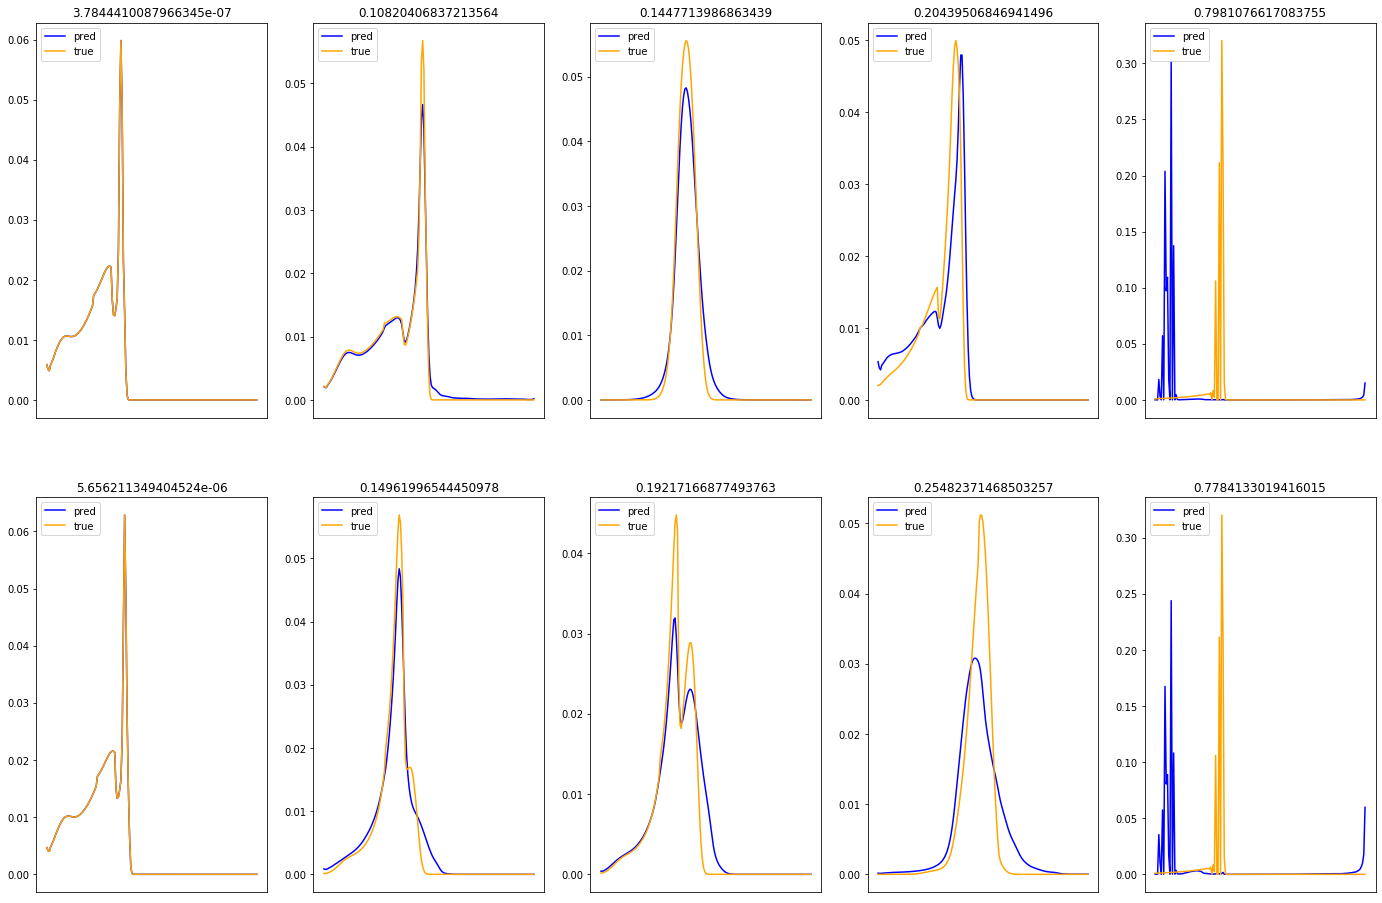

Model 1 Spread
   <js    count   percent
0  0.1  98001.0  0.827180
1  0.2  10746.0  0.090702
2  0.3   4536.0  0.038286
3  0.4   2915.0  0.024604
4  0.5   1697.0  0.014324
5  0.6    415.0  0.003503
6  0.7    144.0  0.001215
7  0.8     22.0  0.000186
8  0.9      0.0  0.000000
9  1.0      0.0  0.000000
Model 2 Spread
   <js    count   percent
0  0.1  90326.0  0.762399
1  0.2  14662.0  0.123755
2  0.3   6478.0  0.054678
3  0.4   3557.0  0.030023
4  0.5   2483.0  0.020958
5  0.6    740.0  0.006246
6  0.7    192.0  0.001621
7  0.8     38.0  0.000321
8  0.9      0.0  0.000000
9  1.0      0.0  0.000000


In [14]:
model_1_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-depth-30-trees-1000-min_samps-56.joblib'
model_2_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-depth-30-trees-1000-min_samps-128.joblib'
compare_two_models(model_1_name, model_2_name)